# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [2]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload

np.warnings = warnings

In [3]:
# import utility functions
import src.utils as utils

# Note: to run main notebook from root directory, use:
ROOT_DIR = Path('')
# setup OS agnostic pathnames
# ROOT_DIR = Path('..')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt

# 1.Dataset Processing

## 1.1 Data Cleaning

Load the dataset. The following tables are loaded for this project:
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [5]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

- The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

- We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [6]:
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)

The Demographic dataframe is a combination of the patient and admission datasets. Adding some columns:
- AGE: the age of the patient at the admitted year
- IS_SEPSIS: indicating whether this is a sepsis case or not


The labevents dataframe is loaded. Admissions under 18 years old are removed

In [7]:
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)

Removed 8210 admissions with AGE < 18


<Axes: title={'center': 'AGE'}, xlabel='IS_SEPSIS'>

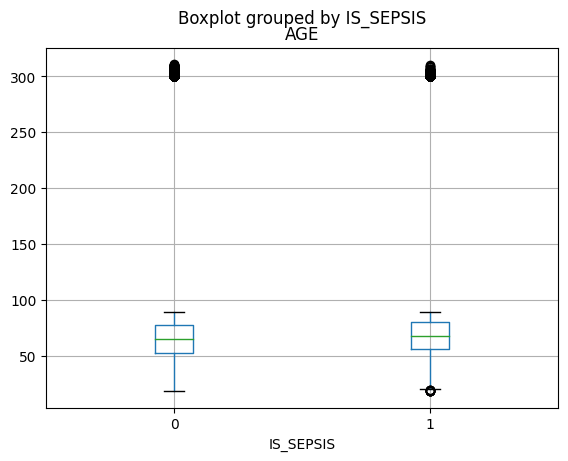

In [8]:
# plotting the age of admissions
df_demographic.boxplot(column=['AGE'], by='IS_SEPSIS')

In [9]:
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
median_age = int(df_demographic['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))

The number of admissions aged over 100 years old is: 2616 admissions (5.15% over all admissions)
The median age of patients: 65


We replace those with aged > 100 by the median age of patients

In [10]:
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)

The labevents dataframe is loaded. The records of admissions under 18 years old are removed.
- The empty HADM_ID is this are cleaned

In [11]:
df_labevents = dataLoader.load_labevents(df_demographic)

Calculate the TIME from for labevents from ADMITTIME to CHARTTIME
- A column NEW_ADMITTIME is added: if CHARTTIME < ADMITTIME, the NEW_ADMITTIME is the CHARTTIME, otherwise, use the ADMITTIME

In [12]:
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

## 1.2 Data Exploration

## 1.3 Feature Selection

# 2.Sepsis Risk Predicting Model Implementation

In [13]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=20)

In [14]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=20)

In [15]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=20)

## 2.1 Survival Analysis

In [62]:
path_t4_df = ROOT_DIR / 'data' / 'Model input data'/"t4.csv"  
t4 = pd.read_csv(path_t4_df)

In [63]:
t4

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,...,ITEMID_51221,ITEMID_51222,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301
0,3,145834,76,0,0,8.0,7.26,329.0,11.0,7.4,...,25.6,8.2,1.7,8.0,81.0,253.0,15.6,15.3,2.79,19.1
1,4,185777,47,1,0,-999.0,-999.00,-999.0,24.0,8.9,...,34.2,11.5,1.0,6.9,89.6,207.0,12.3,13.6,3.80,9.7
2,6,107064,65,1,0,1.9,7.41,153.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0
3,9,150750,41,0,0,-999.0,-999.00,-999.0,30.0,-999.0,...,45.2,15.4,1.1,41.6,50.1,258.0,12.7,13.4,5.46,7.5
4,11,194540,50,1,0,-999.0,-999.00,-999.0,25.0,-999.0,...,36.9,12.5,1.1,7.6,91.4,229.0,13.0,13.4,4.31,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45774,99983,117390,78,0,0,-999.0,-999.00,-999.0,28.0,9.4,...,38.9,13.6,1.1,-999.0,-999.0,253.0,13.4,12.7,4.21,7.5
45775,99985,176670,53,0,1,-999.0,-999.00,-999.0,-999.0,-999.0,...,36.4,12.4,-999.0,8.1,85.1,349.0,-999.0,14.0,4.20,13.0
45776,99992,197084,65,1,0,-999.0,-999.00,-999.0,22.0,7.1,...,12.9,4.7,1.1,9.1,84.9,188.0,12.9,16.3,1.35,21.4
45777,99995,137810,88,1,0,1.1,7.43,382.0,-999.0,-999.0,...,-999.0,-999.0,1.9,-999.0,-999.0,-999.0,19.7,-999.0,-999.00,-999.0


In [64]:
df_demographic[(df_demographic["SUBJECT_ID"]==417) & ( df_demographic["HADM_ID"] == 102633)]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,last_seen,total_stay,status


In [65]:
df_demographic

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,last_seen,total_stay,status
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,F,2131-05-07,0,64,0,51-70,2196-04-10 15:54:00,27.0,False
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,M,2082-07-17,0,71,0,71+,2153-09-08 19:10:00,132.0,False
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,M,2082-07-17,0,75,0,71+,2157-10-25 14:00:00,162.0,False
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,1,M,2100-05-31,0,39,0,36-50,2139-06-09 12:48:00,69.0,False
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,1,M,2101-11-21,0,58,0,51-70,2160-11-05 14:55:00,85.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50761,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,M,2049-07-29,0,78,0,71+,2127-11-11 14:30:00,100.0,False
50762,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,1,M,2044-12-27,1,88,1,71+,2132-12-25 12:00:00,16.0,True
50763,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,1,F,2111-11-05,0,19,0,18-35,2131-04-02 15:02:00,66.0,False
50764,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,1,F,2067-09-21,1,83,0,71+,2151-03-06 09:10:00,13.0,True


In [66]:
t4

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,...,ITEMID_51221,ITEMID_51222,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301
0,3,145834,76,0,0,8.0,7.26,329.0,11.0,7.4,...,25.6,8.2,1.7,8.0,81.0,253.0,15.6,15.3,2.79,19.1
1,4,185777,47,1,0,-999.0,-999.00,-999.0,24.0,8.9,...,34.2,11.5,1.0,6.9,89.6,207.0,12.3,13.6,3.80,9.7
2,6,107064,65,1,0,1.9,7.41,153.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0
3,9,150750,41,0,0,-999.0,-999.00,-999.0,30.0,-999.0,...,45.2,15.4,1.1,41.6,50.1,258.0,12.7,13.4,5.46,7.5
4,11,194540,50,1,0,-999.0,-999.00,-999.0,25.0,-999.0,...,36.9,12.5,1.1,7.6,91.4,229.0,13.0,13.4,4.31,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45774,99983,117390,78,0,0,-999.0,-999.00,-999.0,28.0,9.4,...,38.9,13.6,1.1,-999.0,-999.0,253.0,13.4,12.7,4.21,7.5
45775,99985,176670,53,0,1,-999.0,-999.00,-999.0,-999.0,-999.0,...,36.4,12.4,-999.0,8.1,85.1,349.0,-999.0,14.0,4.20,13.0
45776,99992,197084,65,1,0,-999.0,-999.00,-999.0,22.0,7.1,...,12.9,4.7,1.1,9.1,84.9,188.0,12.9,16.3,1.35,21.4
45777,99995,137810,88,1,0,1.1,7.43,382.0,-999.0,-999.0,...,-999.0,-999.0,1.9,-999.0,-999.0,-999.0,19.7,-999.0,-999.00,-999.0


In [67]:
df_required = pd.merge(t4, df_demographic[["SUBJECT_ID","HADM_ID","total_stay","status"]] , on=["SUBJECT_ID","HADM_ID"], how = 'inner')

In [68]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,...,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301,total_stay,status
0,3,145834,76,0,0,8.0,7.26,329.0,11.0,7.4,...,1.7,8.0,81.0,253.0,15.6,15.3,2.79,19.1,259.0,False
1,4,185777,47,1,0,-999.0,-999.00,-999.0,24.0,8.9,...,1.0,6.9,89.6,207.0,12.3,13.6,3.80,9.7,186.0,False
2,6,107064,65,1,0,1.9,7.41,153.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,393.0,False
3,9,150750,41,0,0,-999.0,-999.00,-999.0,30.0,-999.0,...,1.1,41.6,50.1,258.0,12.7,13.4,5.46,7.5,117.0,True
4,11,194540,50,1,0,-999.0,-999.00,-999.0,25.0,-999.0,...,1.1,7.6,91.4,229.0,13.0,13.4,4.31,8.5,613.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45694,99983,117390,78,0,0,-999.0,-999.00,-999.0,28.0,9.4,...,1.1,-999.0,-999.0,253.0,13.4,12.7,4.21,7.5,74.0,False
45695,99985,176670,53,0,1,-999.0,-999.00,-999.0,-999.0,-999.0,...,-999.0,8.1,85.1,349.0,-999.0,14.0,4.20,13.0,398.0,False
45696,99992,197084,65,1,0,-999.0,-999.00,-999.0,22.0,7.1,...,1.1,9.1,84.9,188.0,12.9,16.3,1.35,21.4,72.0,False
45697,99995,137810,88,1,0,1.1,7.43,382.0,-999.0,-999.0,...,1.9,-999.0,-999.0,-999.0,19.7,-999.0,-999.00,-999.0,77.0,False


In [69]:
df_required = df_required.drop(["SUBJECT_ID","HADM_ID"], axis = 1)

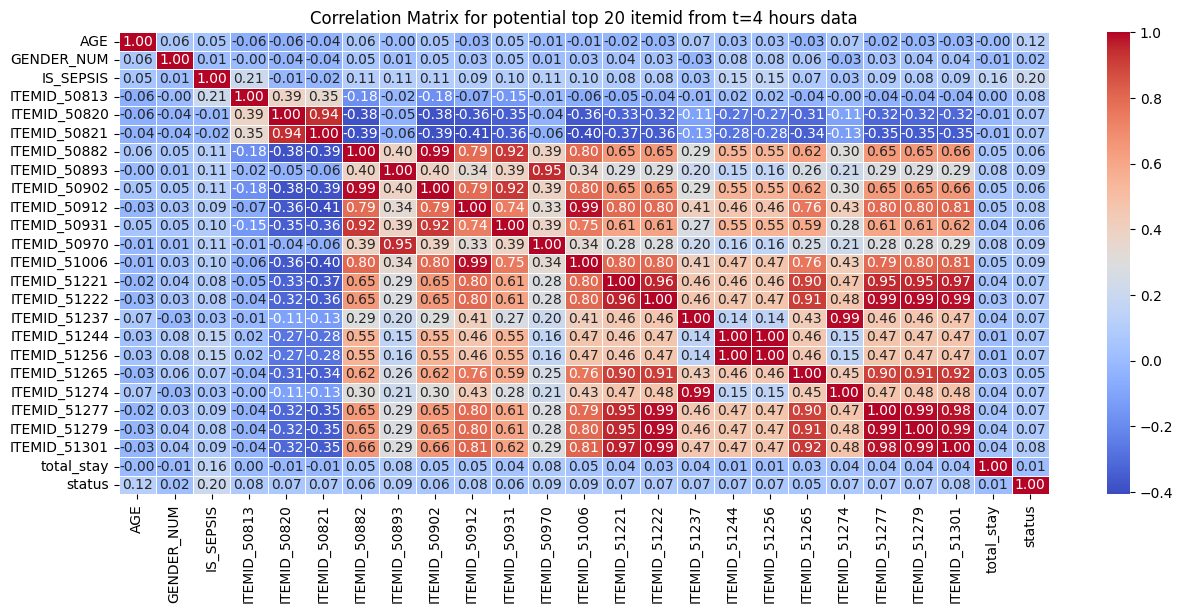

In [70]:
import seaborn as sns
correlation_matrix = df_required.corr()

plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for potential top 20 itemid from t=4 hours data')
plt.show()

In [71]:
df_time = pd.merge(df_labevents[["SUBJECT_ID","HADM_ID","TIME","ITEMID"]],df_demographic[["SUBJECT_ID","HADM_ID","IS_SEPSIS"]], how="inner")

In [72]:
df_time["TIME"].value_counts()

TIME
0.0       1087645
1.0        388049
2.0        229339
4.0        219668
5.0        217691
           ...   
3196.0          1
4213.0          1
3928.0          1
3525.0          1
3574.0          1
Name: count, Length: 4238, dtype: int64

c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


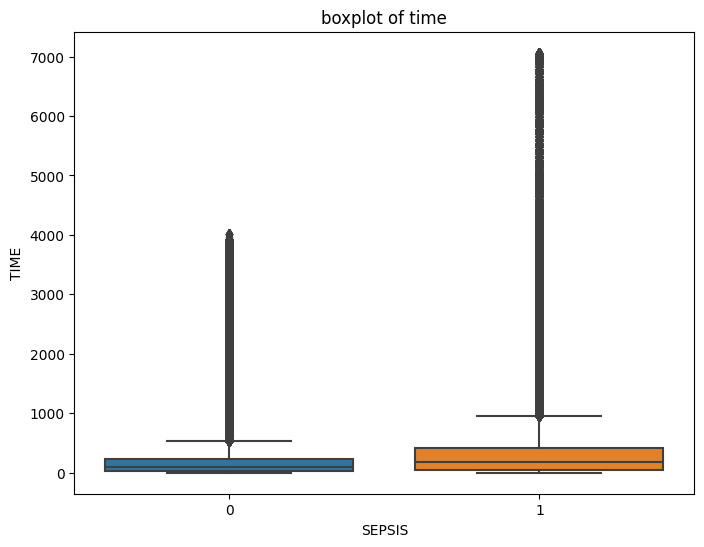

In [73]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='IS_SEPSIS', y='TIME', data=df_time)
plt.title('boxplot of time')
plt.xlabel('SEPSIS')
plt.ylabel('TIME')
plt.show()

   SUBJECT_ID  HADM_ID                TIME
0           1      101 2023-09-26 12:00:00
1           2      102 2023-09-26 14:00:00
2           2      103 2023-09-26 16:00:00
3           3      104 2023-09-26 18:00:00


In [75]:
import pandas as pd

# Assuming you have a DataFrame df with columns SUBJECT_ID, HADM_ID, ITEM_ID, TIME
# Sample data
data = {
    'SUBJECT_ID': [1, 1, 2, 2, 3],
    'HADM_ID': [101, 101, 102, 103, 104],
    'ITEM_ID': [1001, 1002, 1003, 1004, 1005],
    'TIME': ['2023-09-26 10:00:00', '2023-09-26 12:00:00', '2023-09-26 14:00:00', '2023-09-26 16:00:00', '2023-09-26 18:00:00']
}

df = pd.DataFrame(data)

# Convert TIME column to datetime if it's not already
df['TIME'] = pd.to_datetime(df['TIME'])

# Group by SUBJECT_ID and HADM_ID, and find the maximum TIME within each group
result = df.groupby(['SUBJECT_ID', 'HADM_ID'])['TIME'].max().reset_index()

df.groupby(['SUBJECT_ID', 'HADM_ID'])['TIME']


0   2023-09-26 10:00:00
1   2023-09-26 12:00:00
Name: TIME, dtype: datetime64[ns]
2   2023-09-26 14:00:00
Name: TIME, dtype: datetime64[ns]
3   2023-09-26 16:00:00
Name: TIME, dtype: datetime64[ns]
4   2023-09-26 18:00:00
Name: TIME, dtype: datetime64[ns]


## 2.5 LSTM + Attention Model

# 3.Clustering Model

# 4.Model Testing

# 5.Local and Global Feature Explanation